In [3]:
import random

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
seed = 42
random.seed(42)

In [5]:
credit_csv_dir = 'creditcard.csv'
credit = pd.read_csv(credit_csv_dir)

In [6]:
credit_X = credit.drop(labels=['Time','Class'], axis='columns')
credit_Y = credit['Class'].values

In [7]:
X_Train, X_Test, y_train, y_test = train_test_split(credit_X, credit_Y, test_size=0.25, 
                                                    random_state=seed)

In [8]:
print(credit.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [9]:
print(credit.describe(include='all'))

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [10]:
print(credit['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64


In [11]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
X_amt_tr, X_amt_te, y_amt_tr, y_amt_te = train_test_split(
    credit.drop(columns=['Class']).values, credit['Class'].values,
    test_size=0.25, random_state=42)

In [13]:
amt_tr = np.concatenate((X_amt_tr, y_amt_tr.reshape(-1, 1)), axis=1)
amt_tr_df = pd.DataFrame(amt_tr, columns=credit.columns)
amt_te = np.concatenate((X_amt_te, y_amt_te.reshape(-1, 1)), axis=1)
amt_te_df = pd.DataFrame(amt_te, columns=credit.columns)

In [14]:
tl_tr_fraud_amt = amt_tr_df[amt_tr_df['Class'] == 1]['Amount'].sum()
print('{}$'.format(tl_tr_fraud_amt))
tl_te_fraud_amt = amt_te_df[amt_te_df['Class'] == 1]['Amount'].sum()
print('{}$'.format(tl_te_fraud_amt))

42513.46$
17614.51$


In [15]:
# Labels
X_cols = list(credit.drop(labels=['Time', 'Class'], axis='columns').columns)
y_cols = credit[['Class']].columns
target_names = credit['Class'].map(lambda x: 'Non-Fraud' if x==0 else 'Fraud').unique()

In [16]:
# Training data as dataframe

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
X_train_df = pd.DataFrame(X_Train, columns=X_cols)
X_train_df['Amount'] = StandardScaler().fit_transform(
    X_train_df['Amount'].values.reshape(-1, 1))
X_train_df = X_train_df.reset_index().drop(columns=['index'])

In [19]:
y_train_df = pd.DataFrame(y_train, columns=y_cols)
# Full dataframe
train_df = pd.concat([X_train_df, y_train_df], join='outer', axis='columns')

In [20]:
# X, y as numpy array
X_train, y_train = X_train_df.values, y_train_df.values

In [21]:
# Test data as dataframe
X_test_df = pd.DataFrame(X_Test, columns=X_cols)
X_test_df['Amount'] = StandardScaler().fit(
    X_train_df['Amount'].values.reshape(-1, 1)).transform(X_test_df['Amount'].values.reshape(-1, 1))
X_test_df = X_test_df.reset_index().drop(columns=['index'])
y_test_df = pd.DataFrame(y_test, columns=y_cols)
# Full dataframe
test_df = pd.concat([X_test_df, y_test_df], join='outer', axis='columns')
# X, y as numpy array
X_test, y_test = X_test_df.values, y_test_df.values

In [22]:
# Check number of frauds in both training and testing data
print('Number of frauds in training data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_train), y_train.shape[0], np.mean(y_train)*100))
print('Number of frauds in test data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_test), y_test.shape[0], np.mean(y_test)*100))

Number of frauds in training data: 379 out of 213605 cases (0.1774303036% fraud)
Number of frauds in test data: 113 out of 71202 cases (0.1587034072% fraud)


In [23]:
import copy

In [24]:
# 2-component PCA plot
    # PCA is sensitive to dimensional scales, thus the need to standardise matrix X
X_pca = copy.deepcopy(X_train)
y_pca = copy.deepcopy(y_train).reshape(-1,)

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=2, random_state=seed)
X_r = pca.fit_transform(X_pca)

In [27]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.12503723 0.10004168]


In [28]:
import matplotlib.pyplot as plt

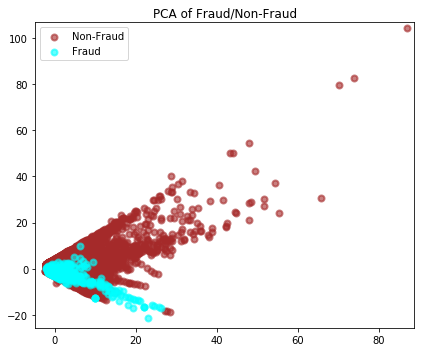

In [29]:
plt.figure(figsize=(6,5)); colors = ['brown', 'cyan']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_pca == i, 0], X_r[y_pca == i, 1], color=color, alpha=.6, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Fraud/Non-Fraud')
plt.tight_layout(); plt.margins(0.02)

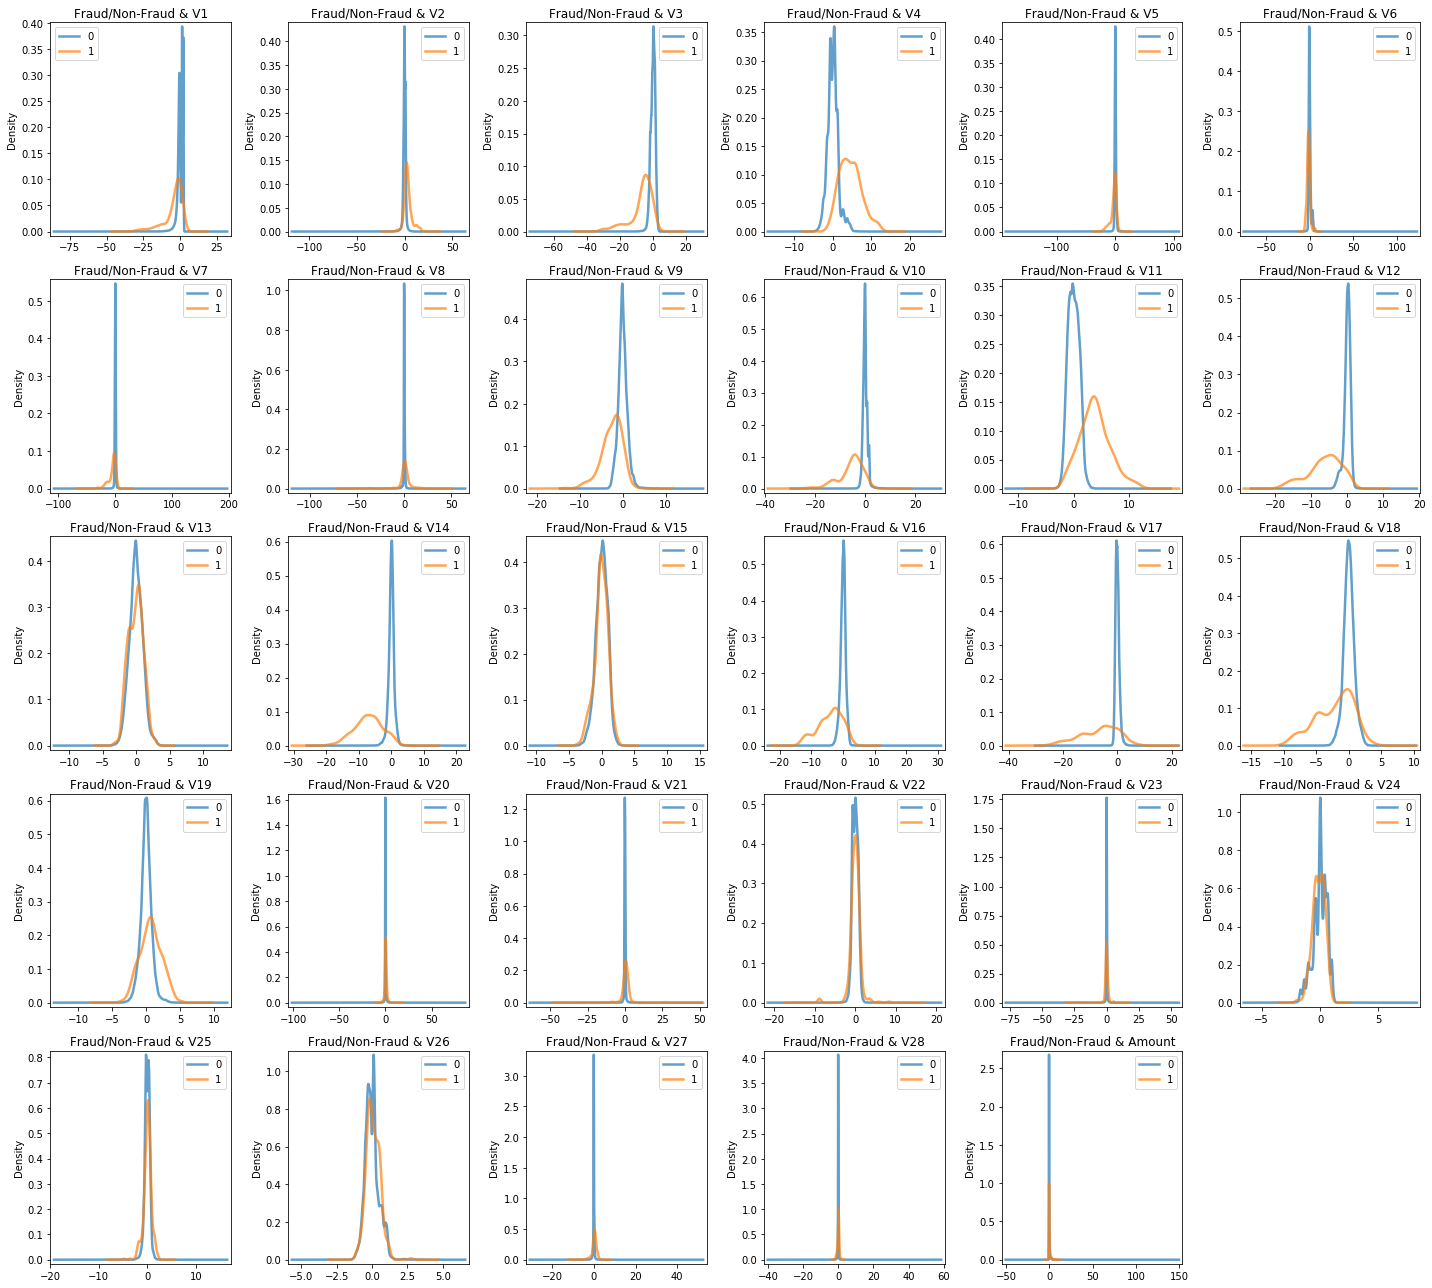

In [30]:
# Kernel Density Distribution subplots against target - 'Class'

# Scatter subplots
plt.figure(figsize=(20,18))
for plot, feat in enumerate(X_cols):
    
    plt.subplot(5, 6, (plot+1))
    title = 'Fraud/Non-Fraud & ' + feat
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='kde', alpha=0.7, legend='best', lw=2.5)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()

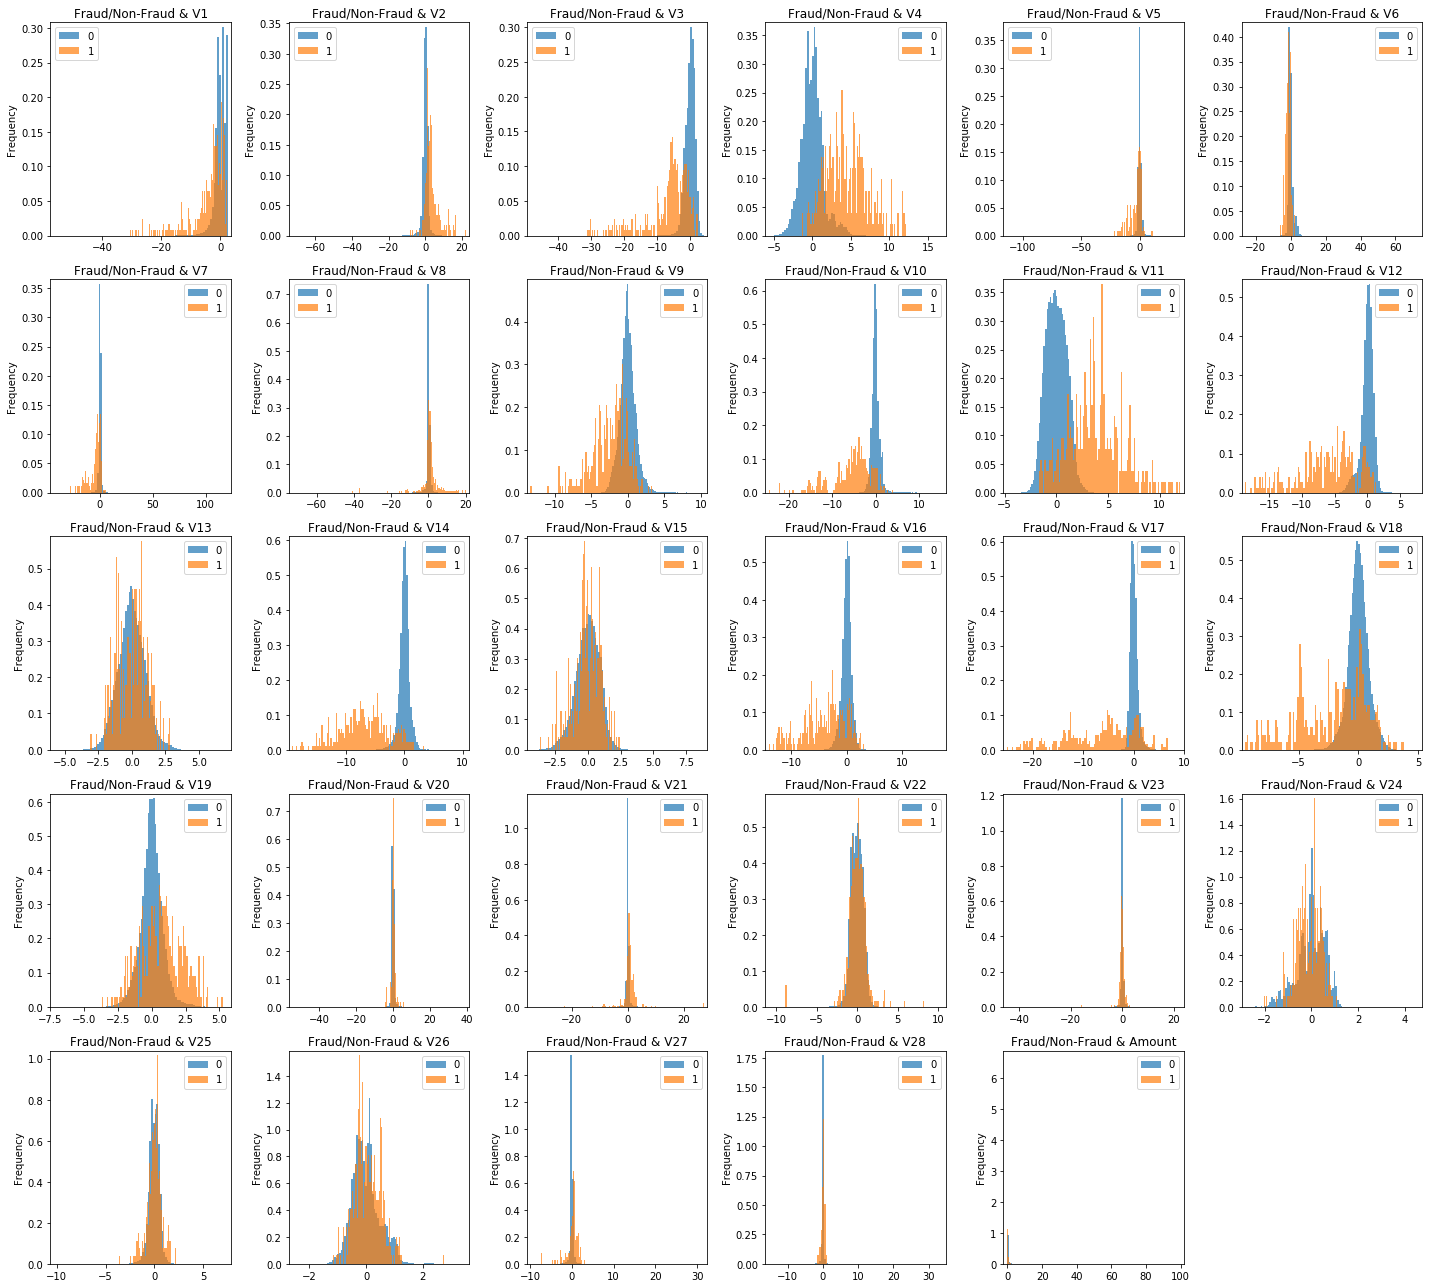

In [31]:

# Histogram Distribution subplots against target - 'Class'

# Scatter subplots
plt.figure(figsize=(20,18))
for plot, feat in enumerate(X_cols):
    
    plt.subplot(5, 6, (plot+1))
    title = 'Fraud/Non-Fraud & ' + feat
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='hist', bins=100, alpha=0.7, 
                                           legend='best', density=True)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()

In [32]:
import scipy.stats as stats

In [33]:
# Perform Wilcoxon Rank-Sum Test at 5% Level to determine feature relevance

# Keep results if needed later
wilcox_result = dict([])

for feat in X_cols:   
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    
    # Draw 300 samples (only 379 fraud data in training set, attempt to draw close to the hilt)
    random.seed(42)
    fraud_wilcox = random.sample(list(temp_df[temp_df['Class']==1][feat]), k=300)
    nonfraud_wilcox = random.sample(list(temp_df[temp_df['Class']==0][feat]), k=300)
    
    rank_sums, p_val_wilcox = stats.wilcoxon(fraud_wilcox, nonfraud_wilcox)
    
    if p_val_wilcox > 0.05:
        wilcox_result[feat] = ('No_Diff', p_val_wilcox)
        print('Feature "{}" failed to be rejected at 5% level with p-value {:.10f}'.format(feat, p_val_wilcox))
    else:
        wilcox_result[feat] = ('Diff', p_val_wilcox)
    
# Rank-Sum Test determined differences in classes within feature
wilcox_feat = [feat for feat in wilcox_result.keys() if wilcox_result[feat][0] == 'Diff']
print('\n', 'Wilcoxon Rank-Sum Relevant Features: ', wilcox_feat)
print('Total number of features selected: {}'.format(len(wilcox_feat)))

Feature "V13" failed to be rejected at 5% level with p-value 0.0973465482
Feature "V15" failed to be rejected at 5% level with p-value 0.8092477538
Feature "V22" failed to be rejected at 5% level with p-value 0.3224055980
Feature "V23" failed to be rejected at 5% level with p-value 0.7011952304
Feature "V26" failed to be rejected at 5% level with p-value 0.5115929524
Feature "Amount" failed to be rejected at 5% level with p-value 0.9531649675

 Wilcoxon Rank-Sum Relevant Features:  ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24', 'V25', 'V27', 'V28']
Total number of features selected: 23


In [34]:
unselected_feats = list(set(X_cols).difference(wilcox_feat))
print('Unselected features: {}'.format(unselected_feats))

Unselected features: ['V23', 'V13', 'Amount', 'V26', 'V15', 'V22']


In [35]:
# Obtain the top 6 most correlated wilcoxon-selected variables' to observe their scatter pair plot relations

# Check for high correlations
wilcox_corr = X_train_df.drop(columns=['V15', 'Amount', 'V13', 'V26', 'V22', 'V23']).corr().abs()
wilcox_corr_pdSr = wilcox_corr.unstack()
wilcox_corr_pdSr_sort = wilcox_corr_pdSr.sort_values(ascending=False).to_frame()

# Top 6 correlated variable pairs
wilcox_corr_pdSr_sort.iloc[23:35:2, :].rename(index=str, columns={0:'pearson_rho'})

pearson_rho
V5 V7     0.030143
V6 V5     0.016899
V7 V3     0.016640
   V6     0.016007
V2 V1     0.015015
V1 V7     0.012172

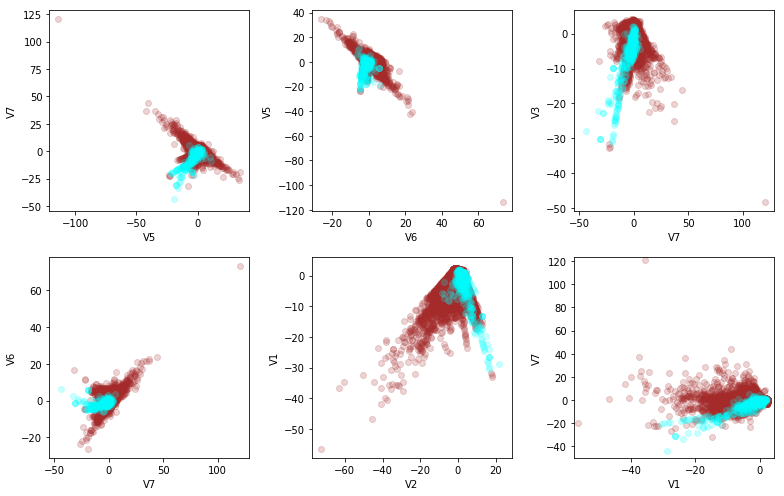

In [36]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

plt.figure(figsize=(11, 7))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(2, 3, (plot+1))
    
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], 
                    group[1][corr_top6[plot][1]], 
                    c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0]); plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

In [37]:
import time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [38]:
# Using default values except "penalty='elasticnet'"
# To preserve/remove meaningful/irrelevant features without absolute purging
sgd_clf = SGDClassifier(penalty='elasticnet', 
                        random_state=seed, class_weight='balanced')

# Measure Start Time
start_time = time.time()

# Fit and obtain predictions
sgd_clf.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values, y_train)
y_hat = sgd_clf.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

pred_score = sgd_clf.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values, y_test)
print('Prediction Score: ', pred_score, '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_hat), '\n')
print('Classification Report:', '\n', classification_report_imbalanced(y_test, y_hat))

/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Time elapsed to train:  0.31200647354125977
Prediction Score:  0.9776129883992023 

Confusion Matrix:  
 [[69505  1584]
 [   10   103]] 

Classification Report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.91      0.99      0.94      0.90     71089
          1       0.06      0.91      0.98      0.11      0.94      0.89       113

avg / total       1.00      0.98      0.91      0.99      0.94      0.90     71202



In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
# Measuring time taken for grid searching the optimal parameters
sgd_params = {'loss':['hinge', 'log', 'modified_huber', 'perceptron'],
              'penalty':['l1', 'l2', 'elasticnet'],
              'alpha':np.logspace(0.0001, 5, 5),
              'l1_ratio':list(np.linspace(0.0001, 1.0, 20))+[0.15],
              'random_state':[42], 
              'n_jobs':[-1],
              'eta0':[0.0001],
              'class_weight':['balanced']}
sgd_gridsearch = GridSearchCV(SGDClassifier(), sgd_params, cv=5, verbose=1, n_jobs=-1)

# Measure Start Time
start_time = time.time()
sgd_gridsearch.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values, y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_hat_grid = sgd_gridsearch.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values)
pred_score_grid = sgd_gridsearch.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).values, y_test)
print('Prediction Score: ', pred_score_grid, '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_hat_grid), '\n')
print('Classification Report:', '\n', classification_report_imbalanced(y_test, y_hat_grid))

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed: 10.8min finished
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in 

Time elapsed to train:  648.4169597625732
Prediction Score:  0.9993539507317211 

Confusion Matrix:  
 [[71071    18]
 [   28    85]] 

Classification Report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.75      1.00      0.87      0.77     71089
          1       0.83      0.75      1.00      0.79      0.87      0.73       113

avg / total       1.00      1.00      0.75      1.00      0.87      0.77     71202



In [41]:
# Print best parameters used in 'GridSearchCV'
print(sgd_gridsearch.best_params_)

{'alpha': 316.2641751796789, 'class_weight': 'balanced', 'eta0': 0.0001, 'l1_ratio': 0.0001, 'loss': 'modified_huber', 'n_jobs': -1, 'penalty': 'elasticnet', 'random_state': 42}


In [42]:
from imblearn import pipeline
from imblearn.over_sampling import RandomOverSampler

In [43]:
# Classifier
sgd_clf = SGDClassifier(penalty='elasticnet', random_state=42, class_weight='balanced')

# Random uniform oversampling
rand = RandomOverSampler(ratio={1:5379}, random_state=42)
    # 'imblearn' upsamples to 5000 observations - 4621 generated + 379 original; to augment by 5000, 'ratio={1:5379}'
pipeline_rand = pipeline.make_pipeline(rand, sgd_clf)

# Measure Start Time
start_time = time.time()

# Train the classifier with balancing
pipeline_rand.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_pred_bal_rand = pipeline_rand.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_rand), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_rand))

/home/chinne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Time elapsed to train:  0.39748597145080566
Confusion Matrix:  
 [[68543  2546]
 [   10   103]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.96      0.91      0.98      0.94      0.88     71089
          1       0.04      0.91      0.96      0.07      0.94      0.87       113

avg / total       1.00      0.96      0.91      0.98      0.94      0.88     71202



/home/chinne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [44]:
from imblearn.over_sampling import SMOTE

In [45]:
# SMOTE
smt = SMOTE(ratio={1:5379}, random_state=42, n_jobs=-1)
pipeline_smt = pipeline.make_pipeline(smt, sgd_clf)

# Measure Start Time
start_time = time.time()

# Train the classifier with balancing
pipeline_smt.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_pred_bal_smt = pipeline_smt.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_smt), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_smt))

/home/chinne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Time elapsed to train:  0.48319482803344727
Confusion Matrix:  
 [[63691  7398]
 [    9   104]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.90      0.92      0.95      0.91      0.82     71089
          1       0.01      0.92      0.90      0.03      0.91      0.83       113

avg / total       1.00      0.90      0.92      0.94      0.91      0.82     71202



/home/chinne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [46]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [47]:
# SMOTE with Tomek Linkages (removing overlaps)
tl = TomekLinks(ratio={1:5379}, random_state=42, n_jobs=-1)
smotetl = SMOTETomek(random_state=42, tomek=tl, smote=smt)
pipeline_smotetl = pipeline.make_pipeline(smotetl, sgd_clf)

# Measure Start Time
start_time = time.time()

# Train the classifier with balancing
pipeline_smotetl.fit(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

y_pred_bal_smotetl = pipeline_smotetl.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix())

# Show the classification report
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_bal_smotetl), '\n')
print(classification_report_imbalanced(y_test, y_pred_bal_smotetl))

/home/chinne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Time elapsed to train:  32.292723655700684
Confusion Matrix:  
 [[65931  5158]
 [   10   103]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.93      0.91      0.96      0.92      0.85     71089
          1       0.02      0.91      0.93      0.04      0.92      0.84       113

avg / total       1.00      0.93      0.91      0.96      0.92      0.85     71202



/home/chinne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [48]:
# Obtain resampled data for plotting
X_rand, y_rand = rand.fit_sample(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
arr_rand = np.concatenate((X_rand, y_rand.reshape(-1, 1)), axis=1)
rand_df = pd.DataFrame(data=arr_rand, columns=(wilcox_feat + ['Class']))

X_smt, y_smt = smt.fit_sample(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
arr_smt = np.concatenate((X_smt, y_smt.reshape(-1, 1)), axis=1)
smt_df = pd.DataFrame(data=arr_smt, columns=(wilcox_feat + ['Class']))

X_smotetl, y_smotetl = smotetl.fit_sample(X_train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22']).as_matrix(), y_train)
arr_smotetl = np.concatenate((X_smotetl, y_smotetl.reshape(-1, 1)), axis=1)
smotetl_df = pd.DataFrame(data=arr_smotetl, columns=(wilcox_feat + ['Class']))

/home/chinne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/chinne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/chinne/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/chinne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will

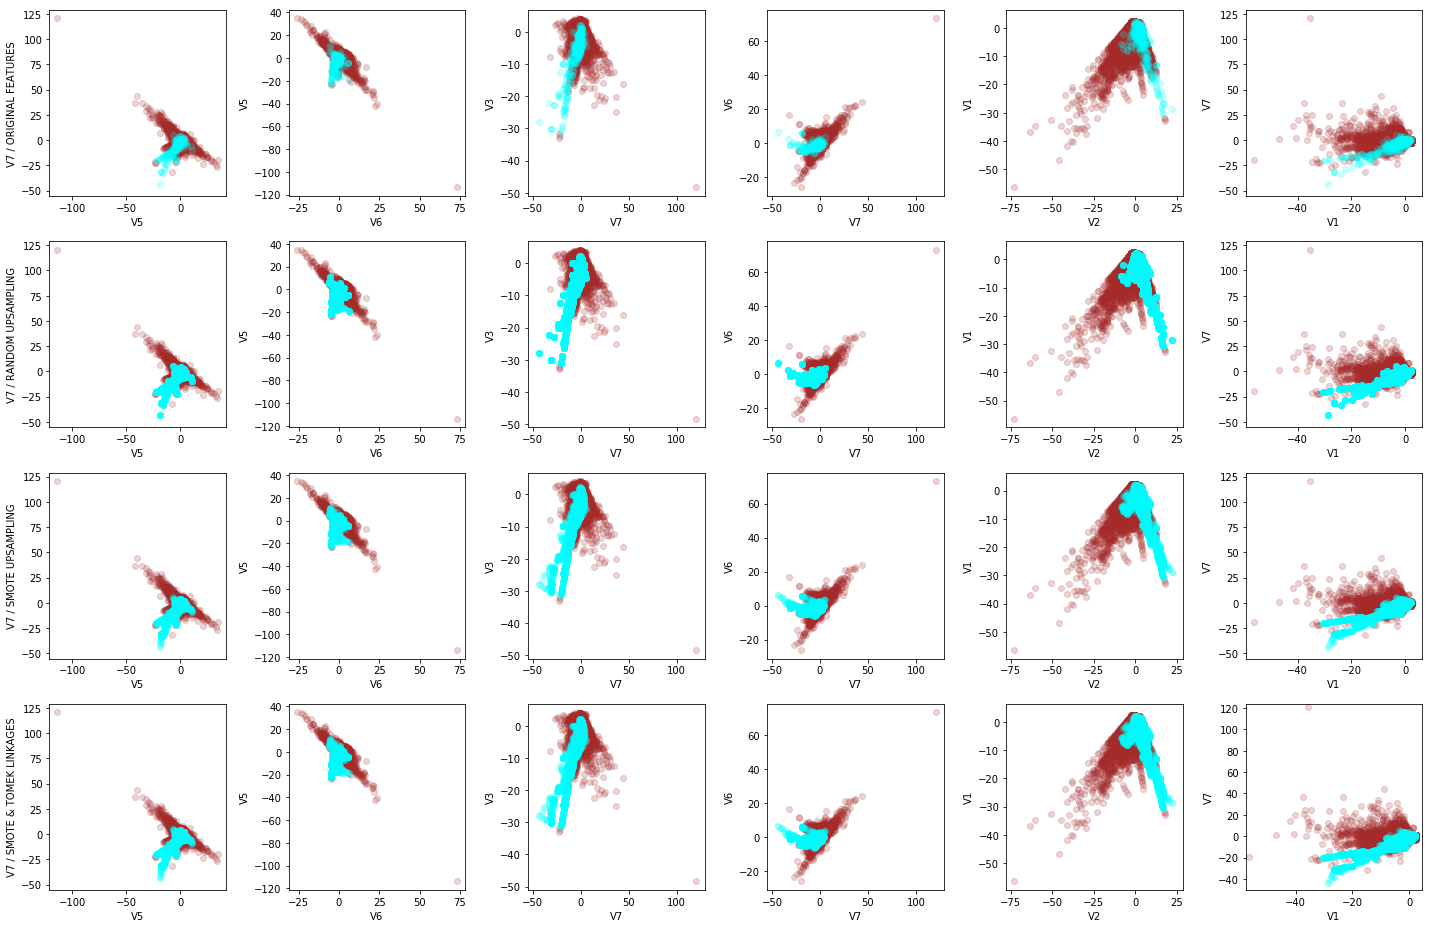

In [49]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

plt.figure(figsize=(20, 13))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(4, 6, (plot+1))
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / ORIGINAL FEATURES')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(4, 6, (plot+7))
    for group, color, label, in zip(rand_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / RANDOM UPSAMPLING')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(4, 6, (plot+13))
    for group, color, label, in zip(smt_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / SMOTE UPSAMPLING')
        else:
            plt.ylabel(corr_top6[plot][1])
        
for plot in range(6):
    plt.subplot(4, 6, (plot+19))
    for group, color, label, in zip(smotetl_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / SMOTE & TOMEK LINKAGES')
        else:
            plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

In [50]:
import torch

In [51]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Measure Start Time
start_time = time.time()

### Training phase ###
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    # Collect list of generator/discriminator losses
    gan_fraud_loss = []
    
    # Collect generated fraud data; Epoch as key, array as values
    gan_fraud_X = {}
    
    ## Execute training epochs ##
    for epoch in range(gan_epochs):
        
        # Feed X mini-batch
        # Drop following variable 'Time'
        split_df_dict = uniform_draw_feat_class(train_df, 'Class', mini_bat)
        fraud_X_mb = split_df_dict[1].drop(columns=['V15', 'V13', 'V23', 
                                                    'Amount', 'V26', 'V22', 'Class']).as_matrix().astype(np.float32)
    
        # Feed prior(z)
        fraud_z_sample = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
        
        # Minimise Losses
        _, fraud_dloss = sess.run([gan_fraud.d_trainer_, gan_fraud.d_loss_], 
                                      feed_dict={gan_fraud.X_: fraud_X_mb, 
                                                 gan_fraud.prior_z_: fraud_z_sample})
        _, fraud_gloss = sess.run([gan_fraud.g_trainer_, gan_fraud.g_loss_], 
                                      feed_dict={gan_fraud.X_: fraud_X_mb,
                                                 gan_fraud.prior_z_: fraud_z_sample})
        
        # Store losses per epoch
        gan_fraud_loss.append((fraud_dloss, fraud_gloss))
        
        if (epoch+1) % 100 == 0 or (epoch+1) == 1:
            # Print generator, discriminator losses for fraudless & fraud cases
            print('Epoch: {}'.format(epoch+1))
            print('Fraud generator loss: {} | discriminator loss: {}'.format(fraud_gloss, fraud_dloss), '\n')
        
        # Store generated data
        fraud_z_gen = np.random.normal(size=[mini_bat, prior_z_dim]).astype(np.float32)
        gan_fraud_X[epoch+1] = sess.run(gan_fraud.gen_X_, feed_dict={gan_fraud.prior_z_: fraud_z_gen})

# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

NameError: name 'tf' is not defined

In [ ]:
import torch.nn as nn

In [ ]:
cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
# House keeping 1
# Impotring libraries we need
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

# Mini-batch size
mb_size = 64

# This will transform data to tensor format which is pytorch's expexted format
transform = transforms.ToTensor()

# Here we download the dataset and trnsfrom it, train=True will only download traning dataset
traindata = torchvision.datasets.MNIST('./NewData/', download=True, transform=transform, train = True)

# Loading the training data
trainloader = torch.utils.data.DataLoader(traindata, shuffle=True, batch_size=mb_size)

In [ ]:
# Just as an example we are going to visualize 

# We define an iterator 

dataiter = iter(trainloader)
imgs, labels = dataiter.next()

def imshow(imgs):
    """ Visualizing images """
    # make_grid will make a grid out of images
    imgs = torchvision.utils.make_grid(imgs)
    
    # transfoming tensors to numpy arrays
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

imshow(imgs)

print(imgs.size())


In [ ]:
# House keeping 2
# Defining the parematers of the network
h_dim = 128    # number of hidden neurons in our hidden layer
Z_dim = 100    # dimension of the input noise for generator
lr = 1e-3      # learning rate
X_dim = imgs.view(imgs.size(0), -1).size(1)
print(X_dim)
